/Users/elafmusa/py312/lib/python3.12/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)



==== Iteration 1/50 – LM ====
[Jacobian] Loading user-specified normal-quadrupole Jacobian from output/jacobians/quads/J_quads_iter1_0.0001urad_200Hz.h5
[Jacobian] Ignoring existing auto file; computing new skew-quadrupole Jacobian (iteration 1).
[calculate_quads_jacobian] Logs saved to '/Users/elafmusa/Desktop/ebs2pySC/pySC_tests/LOCO/output/skew_jacobian_logs.txt'
[Jacobian] Saved skew-quadrupole Jacobian to output/jacobians/skew/J_skew_iter1_0.0001urad_200Hz.h5
Initial Chi²: 2.6484e+06


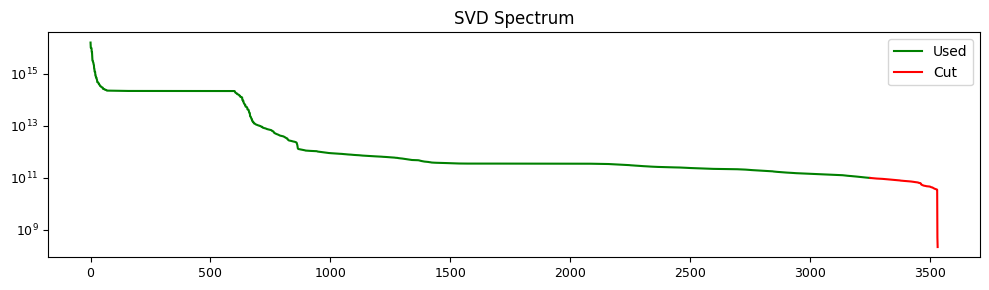

  LM inner 1: chi² 4.9083e+04 (previous 2.6484e+06), λ=0.001
Chi² after correction: 4.9083e+04

==== Iteration 2/50 – LM ====
[Jacobian] Computing normal-quadrupole Jacobian (iteration 2)...
[calculate_quads_jacobian] Logs saved to '/Users/elafmusa/Desktop/ebs2pySC/pySC_tests/LOCO/output/quad_jacobian_logs.txt'
[Jacobian] Computing skew-quadrupole Jacobian (iteration 2)...
[calculate_quads_jacobian] Logs saved to '/Users/elafmusa/Desktop/ebs2pySC/pySC_tests/LOCO/output/skew_jacobian_logs.txt'
Initial Chi²: 4.5405e+04


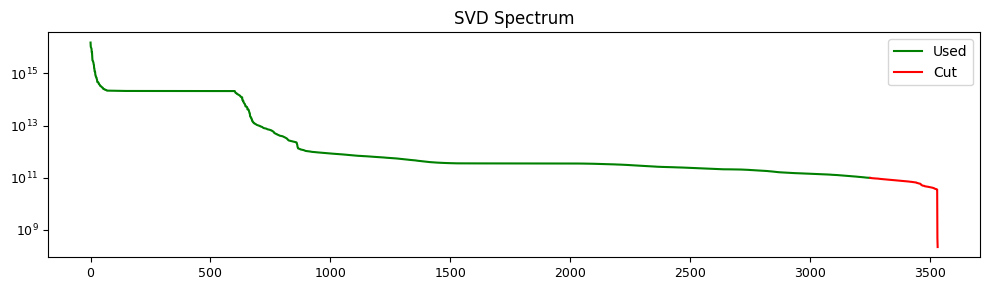

  LM inner 1: chi² 3.9084e+04 (previous 4.5405e+04), λ=0.001
Chi² after correction: 3.9084e+04

==== Iteration 3/50 – LM ====
[Jacobian] Computing normal-quadrupole Jacobian (iteration 3)...
[calculate_quads_jacobian] Logs saved to '/Users/elafmusa/Desktop/ebs2pySC/pySC_tests/LOCO/output/quad_jacobian_logs.txt'
[Jacobian] Computing skew-quadrupole Jacobian (iteration 3)...
[calculate_quads_jacobian] Logs saved to '/Users/elafmusa/Desktop/ebs2pySC/pySC_tests/LOCO/output/skew_jacobian_logs.txt'


In [ ]:
#!/usr/bin/env python
# coding: utf-8
def main():
    from pyLOCO.helpers import load_config
    import os
    import h5py
    from set_correction import last_by_sorted_key, get_quads_block
    import json
    config_path = os.path.abspath("pyloco_config.py")
    load_config(config_path=config_path)
    from pyLOCO.pyloco import pyloco, remove_bad_bpms, plot_data, save_fit_dict
    import numpy as np
    import at
    from pyloco_config import FitInitConfig, fixed_parameters, loco_options

    ring = at.load_lattice('betamodel.mat', use='betamodel')
    ring.disable_6d()
    elements_ind = at.get_refpts(ring, "*")
    cor_indices = at.get_refpts(ring, 'S[HFDIJ]*')
    used_bpm = at.get_refpts(ring, at.elements.Monitor)
    quad_indices = at.get_refpts(ring, at.elements.Quadrupole)
    QD3 = at.get_refpts(ring, 'QD3[AE]*')
    QF4 = at.get_refpts(ring, 'QF4[ABDE]*')
    QD5 = at.get_refpts(ring, 'QD5[BD]*')
    combined = np.concatenate((QD3, QF4, QD5))
    quad_indices = np.sort(combined)
    CAVords = at.get_refpts(ring, at.elements.RFCavity)
    sext_indices = at.get_refpts(ring, at.elements.Sextupole)
    skew_ord = at.get_refpts(ring, 'S[HFDIJ]*')

    _, _, twiss = at.get_optics(ring, elements_ind)
    # ============================================================================== #
    #                Prepare quadrupoles,skews, correctors, bpms, cavity indices
    # ============================================================================== #

    # used_bpm = at.get_refpts(ring, at.elements.Monitor)

    Corords = [cor_indices, cor_indices]
    CAVords = at.get_refpts(ring, at.elements.RFCavity)

    # --- Load Measurments ---
    with h5py.File("./data/measured_orm_loco.h5", "r") as f:
        measured_orm = np.array(f["response_matrix"])  # in meter [BPMs X Cor]

    with h5py.File("./data/measured_dispersion_loco.h5", "r") as f:  # in meter
        measured_eta_x_ = np.array(f["measured_eta_x"])
        measured_eta_y_ = np.array(f["measured_eta_y"])
        attrs_eta = dict(f.attrs)

    with h5py.File("./data/measured_BPM_noise_loco.h5", "r") as f:  # in meter
        Noise_BPMx = np.array(f["Noise_BPMx"])
        Noise_BPMy = np.array(f["Noise_BPMy"])
        attrs_noise = dict(f.attrs)

    # ============================================================================== #
    #               Remove bad BPMs from measurment data
    # ============================================================================== #

    used_bpms_ords = used_bpm

    bad_bpm_positions = np.array([27, 58, 157, 286])
    Noise_BPMx_cleaned = np.delete(Noise_BPMx, bad_bpm_positions)
    Noise_BPMy_cleaned = np.delete(Noise_BPMy, bad_bpm_positions)
    sigma_w = np.concatenate((Noise_BPMx_cleaned, Noise_BPMy_cleaned))[:,
              np.newaxis]  # Note: weight matrix shape for pyloco
    used_bpms_ords = np.delete(used_bpm, bad_bpm_positions)

    # sigma_w = np.concatenate((Noise_BPMx, Noise_BPMy))[:, np.newaxis]
    # used_bpms_ords = used_bpm

    measured_eta_x_ = np.delete(measured_eta_x_, bad_bpm_positions)
    measured_eta_y_ = np.delete(measured_eta_y_, bad_bpm_positions)

    measured_eta_x = measured_eta_x_
    measured_eta_y = measured_eta_y_

    measured_orm, removed = remove_bad_bpms(measured_orm,
                                            bad_bpm_positions,
                                            total_bpms=len(used_bpm),
                                            axis=0,
                                            input_type="positions")
    # If include dispersion is true

    # eta = np.concatenate([measured_eta_x, measured_eta_y])
    # measured_orm = np.hstack((measured_orm, eta.reshape(-1, 1)))

    CMstep = [[100e-6] * len(Corords[0]),
              [100e-6] * len(Corords[1])]

    # In[2]:

    fit_cfg = FitInitConfig()
    ring.disable_6d()
    # --- define arguments ---

    nHorCOR = len(Corords[0])
    nVerCOR = len(Corords[1])
    nHBPM = nVBPM = len(used_bpms_ords)
    nIter = 50

    '''
    fit_list = [
            "quads",
            'skew_quads',
            'quads_tilt',
            "hbpm_gain",
            "vbpm_gain",
            "hcor_cal",
            "vcor_cal",
        "HCMEnergyShift",
        "VCMEnergyShift",
            'hbpm_coupling',
            'vbpm_coupling',
            'hcor_coupling',
            'vcor_coupling'
        ]
    '''
    fit_list = [
            "quads",
            'skew_quads',
            #'quads_tilt',
            "hbpm_gain",
            "vbpm_gain",
            "hcor_cal",
            "vcor_cal",
        "HCMEnergyShift",
        "VCMEnergyShift",
            'hbpm_coupling',
            'vbpm_coupling',
            'hcor_coupling',
            'vcor_coupling'
        ]
    remove_coupling_ = False
    includeDispersion = False
    fixedpathlength = False

    fit_results, fit_dict, ring_pyloco = pyloco(
        ring,

        # --- general control ---
        algorithm=loco_options.algorithm,
        nIter= nIter,

        # --- indices & number of elements ---
        used_bpms_ords=used_bpms_ords,
        used_cor_ords=Corords,
        quads_ords=quad_indices,
        skew_ords=skew_ord,
        CAVords=CAVords,
        nHBPM=nHBPM,
        nVBPM=nVBPM,
        nHorCOR=nHorCOR,
        nVerCOR=nVerCOR,
        quads_tilt_ind=quad_indices,
        inetial_fit_parameters=None,

        # --- measurement data ---
        orm_measured=measured_orm,
        weights=sigma_w,
        includeDispersion=includeDispersion,
        measured_eta_x=measured_eta_x,
        measured_eta_y=measured_eta_y,
        hor_dispersion_weight=loco_options.hor_dispersion_weight,
        ver_dispersion_weight=loco_options.ver_dispersion_weight,

        # --- correctors kicks & RF ---
        CMstep=CMstep,
        rfStep=fixed_parameters.rfstep,
        Frequency=fixed_parameters.Frequency,

        # --- features ---
        fit_list=fit_list,
        individuals=loco_options.individuals,
        remove_coupling_= remove_coupling_,

        # --- outliers & normalization ---
        outlier_rejection=loco_options.outlier_rejection,
        sigma_outlier=loco_options.sigma_outlier,
        apply_normalization=loco_options.apply_normalization,
        normalization_mode=loco_options.normalization_mode,

        # --- SVD selection ---
        svd_selection_method=loco_options.svd_selection_method,
        svd_threshold = loco_options.svd_threshold,
        cut_=loco_options.cut_,
        show_svd_plot=loco_options.show_svd_plot,

        # --- LM options ---
        nLMIter=loco_options.nLMIter,
        Starting_Lambda=loco_options.Starting_Lambda,
        max_lm_lambda=loco_options.max_lm_lambda,
        scaled=loco_options.scaled,

        # --- more options ---
        plot_fit_parameters=loco_options.plot_fit_parameters,
        auto_correct_delta=loco_options.auto_correct_delta,
        fixedpathlength= fixedpathlength,
        fit_cfg=fit_cfg,

        # --- Jacopians files ---

        quad_jacobian_file="output/jacobians/quads/J_quads_iter1_0.0001urad_200Hz.h5",
        skew_jacobian_file=None,
        quads_tilt_jacobian_file=None,
        force_recompute=False
    )

    # --- save results ---
    from pathlib import Path
    save_fit_dict(fit_dict, Path("./output/fit_results_all_parameters"))
    ring_pyloco.save('./output/ring_pyloco.mat', mat_key='ring')


    #fit_dict =  json.load(open("./output/fit_results_all_parameters.json")) ##
    inner = last_by_sorted_key(fit_dict)
    quads_fit, skew_fit = get_quads_block(inner)

    delta_q = np.asarray(
        [quads_fit[i] - ring[quad_indices[i]].K for i in range(len(quad_indices))],
        dtype=float
    ).ravel()

    length_quad = np.asarray(
        [ring[quad_indices[i]].Length for i in range(len(quad_indices))],
        dtype=float
    ).ravel()

    delta_skew = np.asarray(
        [skew_fit[i] - ring[skew_ord[i]].PolynomA[1] for i in range(len(skew_ord))],
        dtype=float
    ).ravel()

    length_skew = np.asarray(
        [ring[skew_ord[i]].Length for i in range(len(skew_ord))],
        dtype=float
    ).ravel()

    delta_dict = {int(indx): delta for indx, delta in zip(quad_indices, -delta_q)}
    deltas_dict = {int(indx): delta for indx, delta in zip(skew_ord, -delta_skew)}

    length_dict = {int(indx): length for indx, length in zip(quad_indices, length_quad)}
    lengths_dict = {int(indx): length for indx, length in zip(skew_ord, length_skew)}

    data_all = {
        "normal_quads": {
            "delta": delta_dict,
            "length": length_dict
        },
        "skew_quads": {
            "delta": deltas_dict,
            "length": lengths_dict
        }
    }

    output_path = Path("./output")
    output_path.mkdir(parents=True, exist_ok=True)

    with open(output_path / "quad_skew_deltas_lengths.json", "w") as f:
        json.dump(data_all, f, indent=4)

    print(f"Saved to {output_path / 'quad_skew_deltas_lengths.json'}")

    print('Lattice tune after loco :' , at.get_tune(ring_pyloco))
    _, _, twiss_err = at.get_optics(ring_pyloco, elements_ind)
    s_pos = twiss_err.s_pos
    bx = (twiss_err.beta[:, 0]) / twiss.beta[:, 0]
    by = (twiss_err.beta[:, 1]) / twiss.beta[:, 1]
    plot_data(s_pos, bx, "s [m]", r"$\Delta\beta_x / \beta_x$ ", "Horizontal beta beating")
    plot_data(s_pos, by, "s [m]", r"$\Delta\beta_y / \beta_y$ ", "Vertical beta beating")


if __name__ == '__main__':
    import multiprocessing as mp
    mp.freeze_support()  # optional on macOS, safe to add
    main()